# EDA : Original

EDA on original KRX data

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
BASE_PATH = Path('.').resolve()
DATA_PATH = BASE_PATH / 'data'

In [3]:
krx_df = pd.read_csv(DATA_PATH / 'train.csv')
krx_df.head()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050


In [4]:
krx_df.tail()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370
987998,20230530,A037440,희림,141932,9170,9260,9170,9200
987999,20230530,A238490,힘스,2611843,6410,8220,6300,8220


In [6]:
krx_df.columns = ['date', 'code', 'name', 'volume', 'open', 'high', 'low', 'close']

In [7]:
krx_df['date'] = pd.to_datetime(krx_df['date'], format='%Y%m%d')

In [9]:
len(krx_df['name'].unique()) # 종목수. 개수상 KOSPI, KOSDAQ 섞여있는 것으로 보임. 

2000

In [12]:
krx_df['date'].unique()[:30] # 모든 날짜가 아닌 거래일만 찍혀있는 것을 확인 가능. 

array(['2021-06-01T00:00:00.000000000', '2021-06-02T00:00:00.000000000',
       '2021-06-03T00:00:00.000000000', '2021-06-04T00:00:00.000000000',
       '2021-06-07T00:00:00.000000000', '2021-06-08T00:00:00.000000000',
       '2021-06-09T00:00:00.000000000', '2021-06-10T00:00:00.000000000',
       '2021-06-11T00:00:00.000000000', '2021-06-14T00:00:00.000000000',
       '2021-06-15T00:00:00.000000000', '2021-06-16T00:00:00.000000000',
       '2021-06-17T00:00:00.000000000', '2021-06-18T00:00:00.000000000',
       '2021-06-21T00:00:00.000000000', '2021-06-22T00:00:00.000000000',
       '2021-06-23T00:00:00.000000000', '2021-06-24T00:00:00.000000000',
       '2021-06-25T00:00:00.000000000', '2021-06-28T00:00:00.000000000',
       '2021-06-29T00:00:00.000000000', '2021-06-30T00:00:00.000000000',
       '2021-07-01T00:00:00.000000000', '2021-07-02T00:00:00.000000000',
       '2021-07-05T00:00:00.000000000', '2021-07-06T00:00:00.000000000',
       '2021-07-07T00:00:00.000000000', '2021-07-08

기본 OHLC + V 데이터 제공. 

- adj Close 처리 안되어 있을 듯 함. 별도 소스에서 찾아야 함. 
    - `fdr` 이용한 naver 수정종가 이용이 유력 - `korquanttools` 와 같은 방법, 다만 추후 데이터 처리 방법도 나와야 하므로 자체 패키지 쓰는 것이 안좋을 수 있음. 
- survivorship bias 존재하는지 확인 필요. 
- KRX event (거래정지 등) 적용 여부 & 가격 데이터 처리 방법 확인 필요. 

## 예상 문제점 확인

결론: 문제 많음. 
- 수정주가 미적용
- survivorship bias 존재

따라서 이 데이터셋은 무시하고 그냥 동일기간에 대해 `korquanttools` 사용해야 정확한 backtest 가능. 

### 1. adj close 미적용

https://kind.krx.co.kr/disclosure/details.do?method=searchDetailsMain

- 6	2023-02-28 17:17	유가증권 국보	주식병합 결정	국보 001140	 
- 5	2023-02-28 16:07	유가증권 일성신약	주식분할 결정	일성신약 003120

<Axes: >

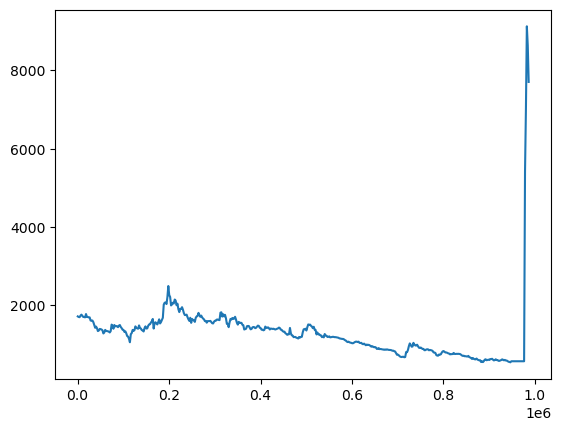

In [15]:
krx_df[krx_df['code'] == 'A001140']['close'].plot()

### 2. survivorship bias

http://open.krx.co.kr/contents/MKD/04/0403/04030300/MKD04030300.jsp

- 208860	엔지스테크널러지	2023/04/18	상장폐지 사유발생
- 117670	알파홀딩스	2023/04/14	상장폐지 사유발생

In [18]:
'A208860' in krx_df['code'].unique()

False

In [19]:
'A117670' in krx_df['code'].unique()

False

<Axes: >

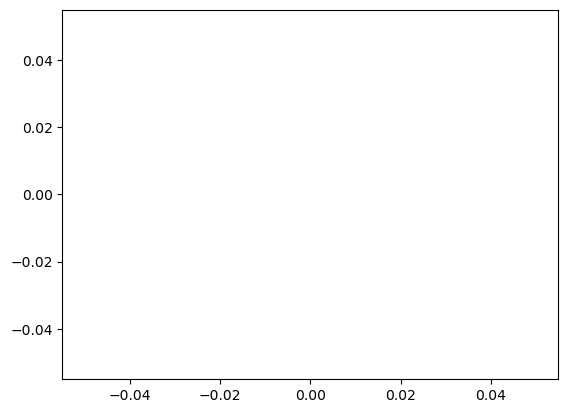

In [16]:
krx_df[krx_df['code'] == 'A208860']['close'].plot()

<Axes: >

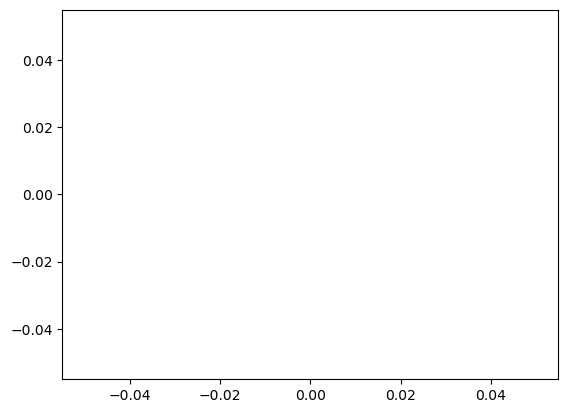

In [17]:
krx_df[krx_df['code'] == 'A117670']['close'].plot()

## 평가방식에 대한 규정 

대회 규정

https://dacon.io/competitions/official/236117/overview/rules

예선 평가 규정

https://dacon.io/competitions/official/236117/talkboard/408727?page=1&dtype=recent

본선 평가 규정 (추후 업데이트)

https://dacon.io/competitions/official/236117/talkboard/408728

### 예선 평가방식 

규정에 의해 알고리즘이 제한되고, 투자 방식도 투기적이 되어야 하는 문제점이 있다. 

본선에선 코스콤 Cloud 상의 더 많은 propriety 데이터 (not 공공) 이 제공되기 떄문에 아예 알고리즘 새로 짜야 함. 

게다가 예선과 달리 실제 program을 돌리는 방식이기 때문에 data frequency 등 알고리즘의 성격도 달라질 수 있다. 

#### 1. 짧은 real OS 기간

- public에서의 simOS 는 5/31 ~ 6/21
- private의 realOS 는 대회 종료 후 7/31 ~ 8/21

대회 평가를 빨리 해야 한다는 압박 때문에 real OS 기간을 1달로 짧게 잡고, 이에 맞춰 simOS 기간을 똑같이 1달로 잡은 것으로 보인다. 

한달 성과, 그것도 simOS와 realOS가 한 달 밖에 떨어져있지 않기 떄문에 

- 5/31~8/21의 regime에 overfitting 시켜야 한다. (최근의 regime이 어떤지에 대한 고민 필요.)
    - 예견편향 있는지 본다고 하였으나, 주어진 데이터부터 예견편향이 내재되어 있음. (survivorship bias)
- realOS의 경우 근미래라 이미 공시 일정이 나와있기 때문에 economic calendar 를 통한 data snooping에 가까운 event 처리가 가능하다. 

#### 2. 200:200 동일 가중 long short 제한

- money neutral하지만 market neutral하지 않을 수 있다. market neutral 맞추기 어렵다. 
- weight 조절이 불가하므로 signal의 강도 조절이 불가능하고, 대신 방향성을 잘 맞춰야 한다. (+/-)

#### 3. Sharpe 산정방식

- simOS, realOS에서 매수/공매도 수익률 산정방식이 cum return이 아니고 holding period return이다. (최대 15일)
    - 이 기간동안 daily trading 못한다. 마지막 날에 정한 long/short 포지션대로 holding하고 15일 뒤 결과를 봐야 한다. 
    - 따라서 알고리즘의 frequency도 이에 맞춰 줄어들어야 한다. daily signal 잡아서 high turnover로 포지션 휙휙 바뀌게 만들 수 없음. 
        - 수수료 및 증권거래세 없다는 가정 있었기 때문에 아쉬운 부분. 
        - 하지만 본선에선 프로그램 돌리는 방식이기 때문에, 본선에선 가능할 것으로 보인다. 
- risk free rate가 3.5%로 고정되어 있다. 
    - 이 rate가 현재 기준금리이고, simOS기간과 realOS 에 적용되기 때문에 평가에선 문제가 없겠지만 
    - 실제 기준금리는 data 시작일 2021/06 ~ 2023/05 까지 매우 급격하게 상승했다. (0.5% --> 3.5%)
        - https://www.bok.or.kr/portal/singl/baseRate/progress.do?dataSeCd=01&menuNo=200656
    - 따라서 backtesting 할 때는 risk free rate 를 고정으로 두지 않고 실제 history에 따라 변동으로 두어야 오래된 시점과 최근 시점의 vertical한 비교가 가능해진다. 
        - 그대로 3.5%로 두고 하면 오래된 성과가 underrated 될 수 있음. 


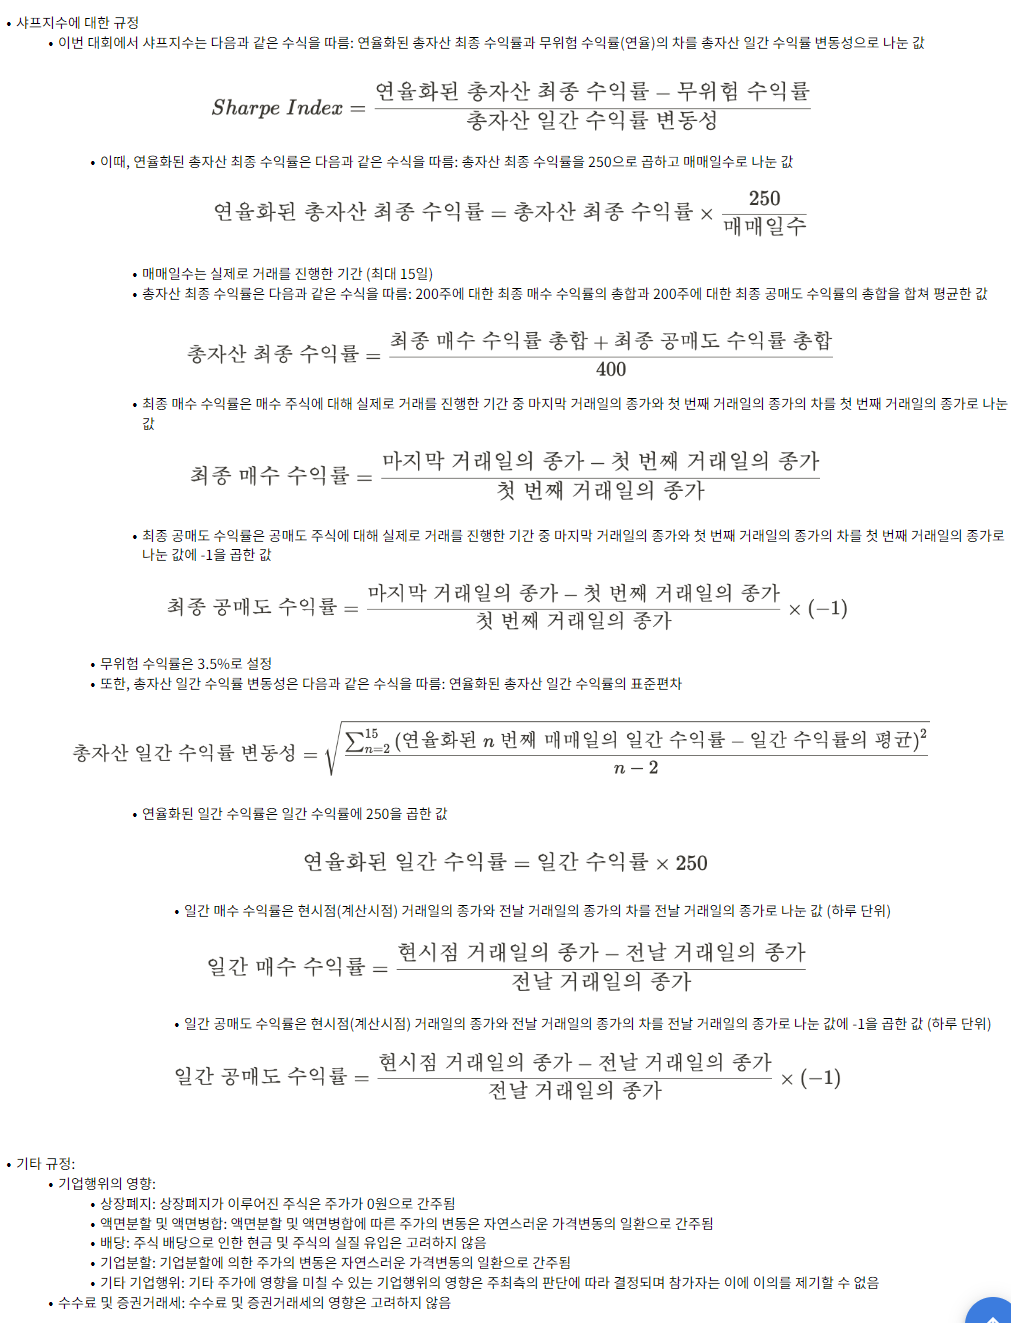





